In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataaruba1/dataAruba1.csv


In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
dataset_path = '/kaggle/input/dataaruba1/dataAruba1.csv'
data = pd.read_csv(dataset_path)
print(data.head())

/kaggle/input/dataaruba1/dataAruba1.csv
   11/4/2010  03:50.2  M003    ON Sleeping begin
0  11/4/2010  03:57.4  M003   OFF      NaN   NaN
1  11/4/2010  15:09.0  T002  21.5      NaN   NaN
2  11/4/2010  30:19.2  T003    21      NaN   NaN
3  11/4/2010  30:19.4  T004    21      NaN   NaN
4  11/4/2010  35:22.2  T005  20.5      NaN   NaN


In [4]:

data = pd.read_csv(dataset_path, delimiter=',', header=None, names=['Date', 'Time', 'Sensor ID', 'State', 'Activity Label', 'Start/End'])
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y', errors='coerce')
def preprocess_time_to_seconds(value):
    try:
        time_parts = value.split(':')
        minutes = int(time_parts[0])
        seconds = float(time_parts[1])
        total_seconds = minutes * 60 + seconds
        return total_seconds
    except (ValueError, IndexError):
        return np.nan 
data['Time_in_Seconds'] = data['Time'].apply(preprocess_time_to_seconds)
def preprocess_state(value):
    if value in ['ON', 'OPEN']:
        return 1.0
    elif value in ['OFF', 'CLOSE']:
        return 0.0
    else:
        try:
            return float(value)
        except ValueError:
            return np.nan
data['State'] = data['State'].apply(preprocess_state)
data['State'] = data['State'].fillna(0.0)
unique_sensor_codes = {}
def get_unique_sensor_code(sensor_id):
    if sensor_id not in unique_sensor_codes:
        unique_sensor_codes[sensor_id] = len(unique_sensor_codes) + 1
    return unique_sensor_codes[sensor_id]
data['Sensor_Unique_Code'] = data['Sensor ID'].apply(get_unique_sensor_code)
def preprocess_sensor_state(row):
    sensor_id = row['Sensor ID']
    state = row['State']
    if sensor_id.startswith('M'):
        return [state, 0.0, 0.0]  
    elif sensor_id.startswith('D'):
        return [0.0, state, 0.0]  
    elif sensor_id.startswith('T'):
        return [0.0, 0.0, float(state)]  
    return [0.0, 0.0, np.nan]  
data[['Sensor_Motion', 'Sensor_Door', 'Sensor_Temperature']] = pd.DataFrame(data.apply(preprocess_sensor_state, axis=1).tolist(), index=data.index)
data['Sensor_Temperature'] = data['Sensor_Temperature'].fillna(data['Sensor_Temperature'].mean())
data['Activity Label'] = data['Activity Label'].fillna('No Activity')
data['Start/End'] = data['Start/End'].fillna('None')
if data.iloc[0]['Start/End'] != 'begin':
    data.at[0, 'Start/End'] = 'begin'
def preprocess_sensor_id(sensor_id):
    if sensor_id.startswith('M'):
        return 1.0  
    elif sensor_id.startswith('D'):
        return 2.0  
    elif sensor_id.startswith('T'):
        return 3.0  
    else:
        return 0.0 
data['Sensor Numeric ID'] = data['Sensor ID'].apply(preprocess_sensor_id)
scaler = MinMaxScaler()
data['State'] = scaler.fit_transform(data[['State']])
temperature_scaler = MinMaxScaler()
data['Sensor_Temperature'] = temperature_scaler.fit_transform(data[['Sensor_Temperature']])
time_scaler = MinMaxScaler()
data['Time_in_Seconds'] = time_scaler.fit_transform(data[['Time_in_Seconds']])
current_activity = 'No Activity'
for index, row in data.iterrows():
    if row['Start/End'] == 'begin':
        current_activity = row['Activity Label']
    elif row['Start/End'] == 'end':
        data.at[index, 'Activity Label'] = current_activity
        current_activity = 'No Activity'
    else:
        data.at[index, 'Activity Label'] = current_activity
label_encoder = LabelEncoder()
data['Activity_Label_Encoded'] = label_encoder.fit_transform(data['Activity Label'])
data = data[['Date', 'Sensor ID', 'Sensor_Unique_Code', 'State', 'Activity_Label_Encoded', 'Start/End',
             'Sensor_Motion', 'Sensor_Door', 'Sensor_Temperature', 'Sensor Numeric ID',
             'Time_in_Seconds']]
sensor_unique_codes = data['Sensor_Unique_Code']
unique_sensor_count = sensor_unique_codes.nunique()
print("Unique Sensor Codes Count:", unique_sensor_count)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)
print("Preprocessed Data Sample:")
print(data.head(5))
print("\nData Shape:", data.shape)

Unique Sensor Codes Count: 39
Label Mapping: {'Bed_to_Toilet': np.int64(0), 'Eating': np.int64(1), 'Enter_Home': np.int64(2), 'Housekeeping': np.int64(3), 'Leave_Home': np.int64(4), 'Meal_Preparation': np.int64(5), 'No Activity': np.int64(6), 'Relax': np.int64(7), 'Respirate': np.int64(8), 'Sleeping': np.int64(9), 'Wash_Dishes': np.int64(10), 'Work': np.int64(11)}
Preprocessed Data Sample:
        Date Sensor ID  Sensor_Unique_Code     State  Activity_Label_Encoded  \
0 2010-11-04      M003                   1  0.003509                       9   
1 2010-11-04      M003                   1  0.000000                       9   
2 2010-11-04      T002                   2  0.075439                       9   
3 2010-11-04      T003                   3  0.073684                       9   
4 2010-11-04      T004                   4  0.073684                       9   

  Start/End  Sensor_Motion  Sensor_Door  Sensor_Temperature  \
0     begin            1.0          0.0            0.000000   


In [5]:

features = ['Time_in_Seconds', 'Sensor_Unique_Code', 'Sensor_Motion',
            'Sensor_Door', 'Sensor_Temperature', 'Activity_Label_Encoded', 'State', 'Sensor Numeric ID']
data = data[features]
data = data.copy()
window_size_seconds = 30  
data['Time_Window'] = (data['Time_in_Seconds'] // window_size_seconds).astype(int)
data['Activity_Group'] = (data['Activity_Label_Encoded'] != data['Activity_Label_Encoded'].shift()).cumsum()
data['Combined_Group'] = data['Time_Window'].astype(str) + "_" + data['Activity_Group'].astype(str)
groups = {group: data for group, data in data.groupby('Combined_Group')}
initial_class_counts = data['Activity_Label_Encoded'].value_counts()
print("تعداد نمونه‌های اولیه کلاس‌ها:")
print(initial_class_counts)
def add_noise_to_minority_classes(data, label_col, features, noise_level=0.05, threshold=200):
    updated_data = data.copy()
    for label, group_data in updated_data.groupby(label_col):
        if len(group_data) < threshold:
            print(f"افزودن نویز به کلاس {label}: تعداد داده‌ها {len(group_data)}")
            noise = np.random.normal(0, noise_level, group_data[features].shape)
            print(f"نویز به ویژگی‌ها برای کلاس {label}:")
            print(noise[:5])  
            updated_features = group_data[features] + noise
            group_data.loc[:, features] = updated_features
            print(f"تغییرات برای نمونه‌های اولیه از ویژگی‌ها برای کلاس {label}:")
            print(group_data[features].head())  # چاپ نمونه‌های اولیه از داده‌ها پس از اعمال نویز
            updated_data.loc[group_data.index] = group_data
    return updated_data
data = add_noise_to_minority_classes(data, 'Activity_Label_Encoded', ['Sensor_Motion', 'Sensor_Door', 'Sensor_Temperature'])
target_class = 6
if target_class in initial_class_counts.index:
    class_6_data = data[data['Activity_Label_Encoded'] == target_class]
    non_class_6_data = data[data['Activity_Label_Encoded'] != target_class]
    frac = 0.05  
    print(f"تعداد نمونه‌های کلاس {target_class} قبل از حذف: {len(class_6_data)}")
    class_6_data = class_6_data.sample(frac=frac, random_state=42)
    print(f"تعداد نمونه‌های کلاس {target_class} بعد از حذف: {len(class_6_data)}")
    data = pd.concat([class_6_data, non_class_6_data])
else:
    print(f"کلاس {target_class} در داده‌ها یافت نشد.")
class_counts_after_downsampling = data['Activity_Label_Encoded'].value_counts()
print(class_counts_after_downsampling)
threshold = class_counts_after_downsampling.median()
def upsample_classes(data, label_col, target_count):
    upsampled_data = []
    for label, group_data in data.groupby(label_col):
        if len(group_data) < target_count:
            print(f"آپ‌سمپلینگ کلاس {label}: {len(group_data)} -> {target_count}")
            group_data = group_data.sample(int(target_count), replace=True, random_state=42)
        upsampled_data.append(group_data)
    return pd.concat(upsampled_data, ignore_index=True)
data = upsample_classes(data, 'Activity_Label_Encoded', threshold)
class_counts_after_upsampling = data['Activity_Label_Encoded'].value_counts()
print("تعداد نمونه‌های کلاس‌ها بعد از آپ‌سمپلینگ:")
print(class_counts_after_upsampling)
window = 30  
features_size = len(features) - 1
x = []
y = []
for group_id, group_data in data.groupby('Combined_Group'):
    y.append(group_data['Activity_Label_Encoded'].iloc[0])  # برچسب غالب
    c_data = group_data[group_data.columns.drop(['Activity_Label_Encoded', 'Combined_Group', 'Activity_Group', 'Time_Window'])]
    x.append(c_data.values.tolist())
def adjust_array(arr):
    new_arr = []
    new_arr.extend(arr)
    if len(arr) < window:
        adden = [0] * features_size
        less_size = window - len(arr)
        for i in range(less_size):
            new_arr.append(adden)
    elif len(arr) > window:
        new_arr = new_arr[window * -1:]
    return new_arr
adjusted_arrays = [adjust_array(arr) for arr in x]
y = np.array(y)
print(f"تعداد نمونه‌ها: {len(data)}")
print(f"اندازه x: {len(adjusted_arrays)}, شکل هر نمونه: {len(adjusted_arrays[0])}x{len(adjusted_arrays[0][0])}")
print(f"اندازه y: {len(y)}")


تعداد نمونه‌های اولیه کلاس‌ها:
Activity_Label_Encoded
6     574519
7     207900
5     173272
9      45457
1      12103
11     11459
3      10938
10      9255
4       1242
2       1197
0       1011
8        223
Name: count, dtype: int64
تعداد نمونه‌های کلاس 6 قبل از حذف: 574519
تعداد نمونه‌های کلاس 6 بعد از حذف: 28726
Activity_Label_Encoded
7     207900
5     173272
9      45457
6      28726
1      12103
11     11459
3      10938
10      9255
4       1242
2       1197
0       1011
8        223
Name: count, dtype: int64
آپ‌سمپلینگ کلاس 0: 1011 -> 11198.5
آپ‌سمپلینگ کلاس 2: 1197 -> 11198.5
آپ‌سمپلینگ کلاس 3: 10938 -> 11198.5
آپ‌سمپلینگ کلاس 4: 1242 -> 11198.5
آپ‌سمپلینگ کلاس 8: 223 -> 11198.5
آپ‌سمپلینگ کلاس 10: 9255 -> 11198.5
تعداد نمونه‌های کلاس‌ها بعد از آپ‌سمپلینگ:
Activity_Label_Encoded
7     207900
5     173272
9      45457
6      28726
1      12103
11     11459
0      11198
2      11198
3      11198
4      11198
8      11198
10     11198
Name: count, dtype: int64
تعداد نمونه‌ها: 5

In [6]:

x = np.array(adjusted_arrays)
y = np.array(y).reshape(-1, 1)
total_size = y.shape[0]
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  
X_train = x[:train_size, :, :]
y_train = y[:train_size, :]
X_val = x[train_size:train_size + val_size, :, :]
y_val = y[train_size:train_size + val_size, :]
X_test = x[train_size + val_size:, :, :]
y_test = y[train_size + val_size:, :]
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4942, 30, 7)
y_train shape: (4942, 1)
X_val shape: (706, 30, 7)
y_val shape: (706, 1)
X_test shape: (1413, 30, 7)
y_test shape: (1413, 1)


In [7]:

class ActivityDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
train_dataset = ActivityDataset(X_train, y_train)
val_dataset = ActivityDataset(X_val, y_val)
test_dataset = ActivityDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")


Training data shape: (4942, 30, 7)
Validation data shape: (706, 30, 7)
Test data shape: (1413, 30, 7)
Training labels shape: (4942, 1)
Validation labels shape: (706, 1)
Test labels shape: (1413, 1)


In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_tensor_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_tensor_train = torch.tensor(y_train, dtype=torch.long, device=device).view(-1)
x_tensor_val = torch.tensor(X_val, dtype=torch.float32, device=device)
y_tensor_val = torch.tensor(y_val, dtype=torch.long, device=device).view(-1)
x_tensor_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device).view(-1)
mask_ratio = 0.5  
unique_classes = torch.unique(y_tensor_train)  
labeled_indices = []
unlabeled_indices = []
for class_label in unique_classes:
    class_indices = torch.where(y_tensor_train == class_label)[0]  
    class_indices = class_indices[torch.randperm(class_indices.shape[0], device=device)]  
    num_labeled = int(len(class_indices) * (1 - mask_ratio)) 
    labeled_indices.extend(class_indices[:num_labeled].tolist())  
    unlabeled_indices.extend(class_indices[num_labeled:].tolist())  
labeled_indices = torch.tensor(labeled_indices, device=device)
unlabeled_indices = torch.tensor(unlabeled_indices, device=device)
x_labeled = x_tensor_train[labeled_indices]
y_labeled = y_tensor_train[labeled_indices]
x_unlabeled = x_tensor_train[unlabeled_indices]
y_unlabeled = y_tensor_train[unlabeled_indices]  
print(f"Total training samples: {y_tensor_train.shape[0]}")
print(f"Labeled samples: {x_labeled.shape[0]}, Unlabeled samples: {x_unlabeled.shape[0]}")
print("Labeled class distribution:", torch.bincount(y_labeled))
print("Unlabeled class distribution:", torch.bincount(y_unlabeled))
print(f"Labeled samples: {x_labeled.shape[0]}, Unlabeled samples: {x_unlabeled.shape[0]}")
print(f"y_labeled shape: {y_labeled.shape}, y_unlabeled shape: {y_unlabeled.shape}")
print(f"x_tensor_test: {x_tensor_test.shape}, y_tensor_test: {y_tensor_test.shape}")
print(f"x_tensor_val: {x_tensor_val.shape}, y_tensor_val: {y_tensor_val.shape}")
print("First 10 labeled indices:", labeled_indices[:10].cpu().tolist())
print("First 10 unlabeled indices:", unlabeled_indices[:10].cpu().tolist())
print("First 10 labeled labels:", y_labeled[:10].cpu().tolist())
print("First 10 unlabeled labels (for verification):", y_unlabeled[:10].cpu().tolist())


Total training samples: 4942
Labeled samples: 2470, Unlabeled samples: 2472
Labeled class distribution: tensor([  41,   66,   99,   12,   99,  318, 1063,  623,    1,   89,   21,   38],
       device='cuda:0')
Unlabeled class distribution: tensor([  41,   67,   99,   12,  100,  318, 1063,  623,    1,   89,   21,   38],
       device='cuda:0')
Labeled samples: 2470, Unlabeled samples: 2472
y_labeled shape: torch.Size([2470]), y_unlabeled shape: torch.Size([2472])
x_tensor_test: torch.Size([1413, 30, 7]), y_tensor_test: torch.Size([1413])
x_tensor_val: torch.Size([706, 30, 7]), y_tensor_val: torch.Size([706])
First 10 labeled indices: [344, 1484, 3467, 2437, 2271, 97, 889, 827, 160, 757]
First 10 unlabeled indices: [1654, 1897, 4929, 455, 1967, 2673, 36, 1899, 4055, 346]
First 10 labeled labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First 10 unlabeled labels (for verification): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Device: cuda
Epoch [50/500], Train Loss: 3.1163, Validation Loss: 2.6526
Epoch [100/500], Train Loss: 1.7565, Validation Loss: 2.2939
Epoch [150/500], Train Loss: 0.9236, Validation Loss: 1.9346
Epoch [200/500], Train Loss: 0.1483, Validation Loss: 1.1530
Epoch [250/500], Train Loss: 0.0522, Validation Loss: 1.0924
Epoch [300/500], Train Loss: 0.0325, Validation Loss: 1.0573
Epoch [350/500], Train Loss: 0.0239, Validation Loss: 1.0210
Epoch [400/500], Train Loss: 0.0179, Validation Loss: 0.9949
Epoch [450/500], Train Loss: 0.0146, Validation Loss: 0.9673
Epoch [500/500], Train Loss: 0.0121, Validation Loss: 0.9479


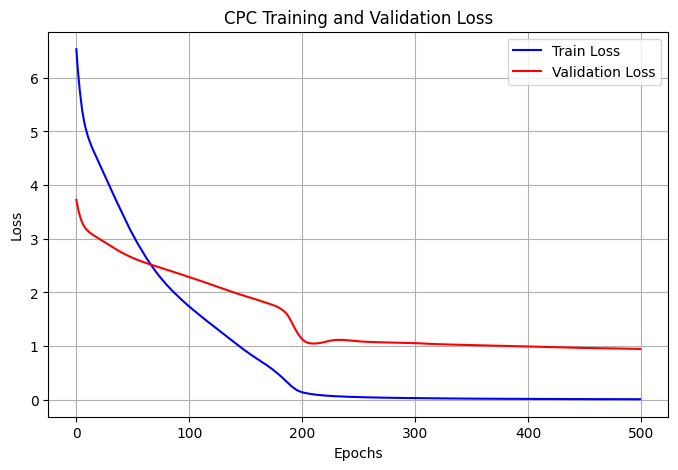

cpc_features_labeled shape: torch.Size([2470, 30, 128])
cpc_features_unlabeled shape: torch.Size([2472, 30, 128])
cpc_features_val shape: torch.Size([706, 30, 128])
cpc_features_test shape: torch.Size([1413, 30, 128])


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
class CPCModel(nn.Module):
    def __init__(self, input_dim, latent_dim, num_gru_layers, dropout_rate=0.1):
        super(CPCModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, latent_dim)
        )
        self.rnn = nn.GRU(
            input_size=latent_dim,
            hidden_size=128,
            num_layers=num_gru_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout_rate
        )

    def forward(self, x):
        z = self.encoder(x)          # (batch_size, seq_len, latent_dim)
        context, _ = self.rnn(z)     # (batch_size, seq_len, hidden_size)
        return context              
def info_nce_loss(context, temperature=0.1):
    batch_size, seq_len, hidden_dim = context.shape
    similarities = torch.matmul(context, context.transpose(1, 2)) / temperature
    labels = torch.arange(seq_len, device=device).repeat(batch_size, 1)
    loss = nn.CrossEntropyLoss()(similarities.reshape(-1, seq_len), labels.reshape(-1))
    return loss
input_dim = x_labeled.shape[2]  
latent_dim = 128
num_gru_layers = 2
dropout_rate = 0.1
weight_decay = 1e-5
learning_rate = 1e-4
num_epochs = 500
cpc_model = CPCModel(input_dim, latent_dim, num_gru_layers, dropout_rate).to(device)
optimizer = optim.Adam(cpc_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    cpc_model.train()
    optimizer.zero_grad()
    context_labeled = cpc_model(x_labeled)
    context_unlabeled = cpc_model(x_unlabeled)
    loss_labeled = info_nce_loss(context_labeled, temperature=0.5)
    loss_unlabeled = info_nce_loss(context_unlabeled, temperature=0.5)
    total_loss = loss_labeled + loss_unlabeled
    total_loss.backward()
    optimizer.step()
    train_losses.append(total_loss.item())
    cpc_model.eval()
    with torch.no_grad():
        context_val = cpc_model(x_tensor_val)
        val_loss = info_nce_loss(context_val, temperature=0.5)
        val_losses.append(val_loss.item())
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('CPC Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
cpc_model.eval()
with torch.no_grad():
    cpc_features_labeled = cpc_model(x_labeled).clone().detach().to(device, dtype=torch.float32)
    cpc_features_unlabeled = cpc_model(x_unlabeled).clone().detach().to(device, dtype=torch.float32)
    cpc_features_val = cpc_model(x_tensor_val).clone().detach().to(device, dtype=torch.float32)
    cpc_features_test = cpc_model(x_tensor_test).clone().detach().to(device, dtype=torch.float32)
print(f'cpc_features_labeled shape: {cpc_features_labeled.shape}')
print(f'cpc_features_unlabeled shape: {cpc_features_unlabeled.shape}')
print(f'cpc_features_val shape: {cpc_features_val.shape}')
print(f'cpc_features_test shape: {cpc_features_test.shape}')


In [10]:

cpc_features_unlabeled = cpc_features_unlabeled.clone().detach().to(device)  
cpc_features_labeled = cpc_features_labeled.clone().detach().to(device)      
cpc_features_test = cpc_features_test.clone().detach().to(device)            
cpc_features_val = cpc_model(x_tensor_val)[0].clone().detach().to(device)    
y_tensor_labeled = y_labeled.clone().detach().to(device).long()
y_tensor_unlabeled = y_unlabeled.clone().detach().to(device).long()
y_tensor_test = y_tensor_test.clone().detach().to(device).long().squeeze()  
y_tensor_val = y_tensor_val.clone().detach().to(device).long()
print(f'cpc_features_unlabeled shape: {cpc_features_unlabeled.shape}')  # (num_unlabeled, seq_len, latent_dim)
print(f'cpc_features_labeled shape: {cpc_features_labeled.shape}')      # (num_labeled, seq_len, latent_dim)
print(f'cpc_features_test shape: {cpc_features_test.shape}')            # (num_test, seq_len, latent_dim)
print(f'cpc_features_val shape: {cpc_features_val.shape}')              # (num_val, seq_len, latent_dim)
print(f'y_tensor_labeled shape: {y_tensor_labeled.shape}')              # (num_labeled,)
print(f'y_tensor_unlabeled shape: {y_tensor_unlabeled.shape}')          # (num_unlabeled,)
print(f'y_tensor_test shape: {y_tensor_test.shape}')                    # (num_test,)
print(f'y_tensor_val shape: {y_tensor_val.shape}')                      # (num_val,)


cpc_features_unlabeled shape: torch.Size([2472, 30, 128])
cpc_features_labeled shape: torch.Size([2470, 30, 128])
cpc_features_test shape: torch.Size([1413, 30, 128])
cpc_features_val shape: torch.Size([30, 128])
y_tensor_labeled shape: torch.Size([2470])
y_tensor_unlabeled shape: torch.Size([2472])
y_tensor_test shape: torch.Size([1413])
y_tensor_val shape: torch.Size([706])


Embedding shape after pooling: (1413, 128)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


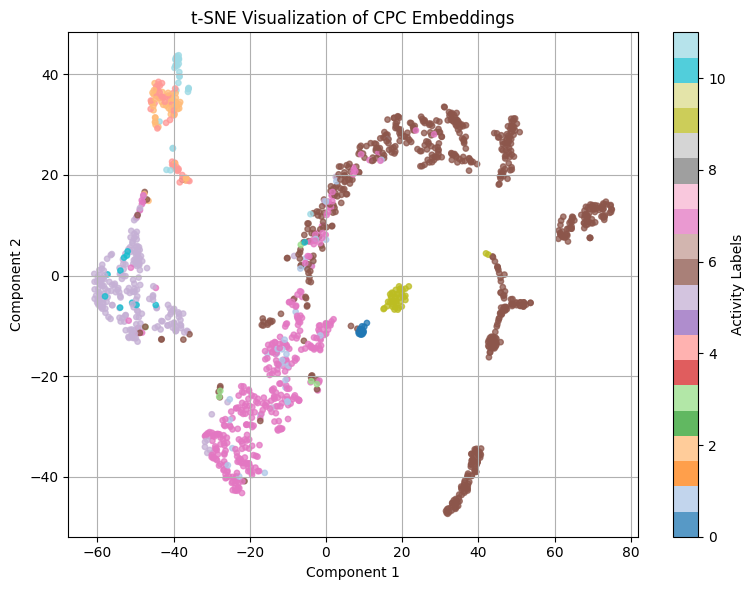

In [11]:

cpc_model.eval()
with torch.no_grad():
    cpc_embeddings = cpc_model(x_tensor_test).cpu().numpy()
cpc_embeddings_mean = cpc_embeddings.mean(axis=1)
true_labels = np.asarray(y_test)
print("Embedding shape after pooling:", cpc_embeddings_mean.shape)
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=2000,
    random_state=42
)

X_2d = tsne.fit_transform(cpc_embeddings_mean)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=true_labels,
    cmap='tab20',
    s=15,
    alpha=0.75
)
plt.colorbar(scatter, label="Activity Labels")
plt.title("t-SNE Visualization of CPC Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


2025-12-23 06:01:52.591497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766469712.794847      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766469712.851237      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766469713.356559      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766469713.356603      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766469713.356606      55 computation_placer.cc:177] computation placer alr

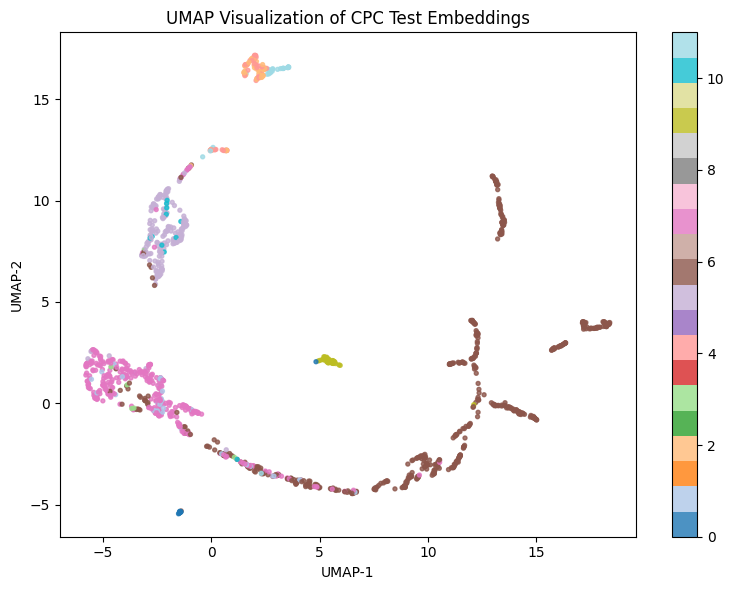

In [12]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Mean pooling روی embedding تست
cpc_embeddings_mean = cpc_features_test.mean(dim=1).cpu().numpy()

true_labels = y_test  # اگر numpy است، .cpu() نزن

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

X_umap = reducer.fit_transform(cpc_embeddings_mean)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=true_labels,
    cmap='tab20',
    s=8,
    alpha=0.8
)
plt.colorbar(scatter)
plt.title("UMAP Visualization of CPC Test Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


Using device: cuda
Epoch [50/500] - Train Loss: 0.5471, Val Loss: 0.4563
Epoch [100/500] - Train Loss: 0.2864, Val Loss: 0.3348
Early stopping at epoch 129
Train Metrics:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.73      0.22      0.33        37
           2       0.53      0.71      0.61        78
           3       0.00      0.00      0.00        10
           4       0.52      0.40      0.45        70
           5       0.88      0.97      0.92       217
           6       0.97      0.98      0.98       748
           7       0.91      0.96      0.93       434
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00        64
          10       0.00      0.00      0.00        18
          11       0.90      0.64      0.75        28

    accuracy                           0.90      1729
   macro avg       0.62      0.57      0.58      1729
weighted avg    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

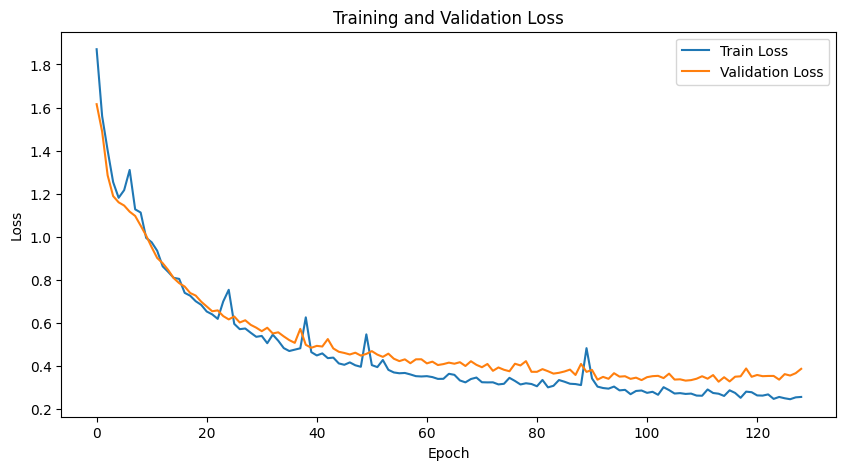

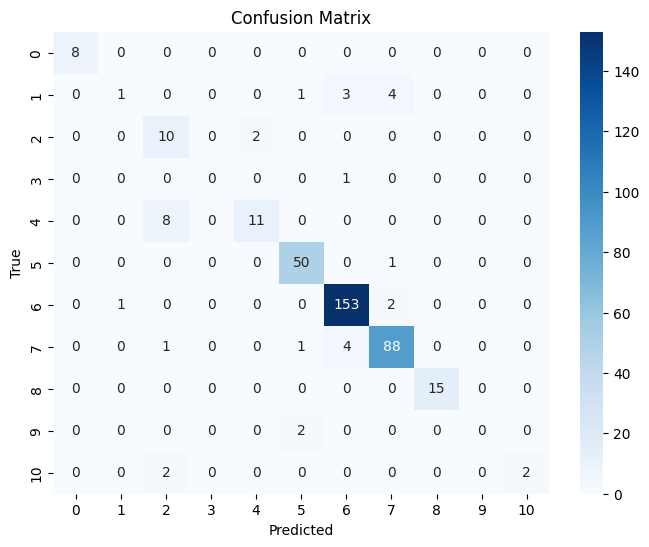

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]
class TransformerGRU(nn.Module):
    def __init__(self, input_dim, num_classes, unique_sensor_dim, d_model=256, num_heads=4, gru_hidden_sizes=[64,128,128], dropout=0.5):
        super().__init__()
        self.sensor_embedding = nn.Embedding(unique_sensor_dim, d_model)
        self.feature_embedding = nn.Linear(input_dim-1, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True, dropout=dropout)
        self.gru1 = nn.GRU(d_model, gru_hidden_sizes[0], batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(gru_hidden_sizes[0]*2, gru_hidden_sizes[1], batch_first=True, bidirectional=True)
        self.gru3 = nn.GRU(gru_hidden_sizes[1]*2, gru_hidden_sizes[2], batch_first=True, bidirectional=True)
        self.fc = nn.Linear(d_model + gru_hidden_sizes[2]*2, num_classes)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        sensor_feat = x[:,:,0].long()
        other_feat = x[:,:,1:]
        sensor_emb = self.sensor_embedding(sensor_feat)
        other_emb = self.feature_embedding(other_feat)
        combined = sensor_emb + other_emb
        combined = self.pos_encoding(combined)
        attn_out,_ = self.attn(combined, combined, combined)
        attn_out = attn_out.mean(dim=1)
        gru_out,_ = self.gru1(combined)
        gru_out,_ = self.gru2(gru_out)
        gru_out,_ = self.gru3(gru_out)
        gru_out_last = torch.cat((gru_out[:, -1, :gru_out.shape[2]//2], gru_out[:,0, gru_out.shape[2]//2:]), dim=1)
        combined_out = torch.cat((attn_out, gru_out_last), dim=1)
        combined_out = self.dropout(combined_out)
        output = self.fc(combined_out)
        return output
def align_features_labels(features, labels):
    min_len = min(features.shape[0], labels.shape[0])
    return features[:min_len], labels[:min_len]
cpc_features_labeled, y_tensor_labeled = align_features_labels(cpc_features_labeled, y_tensor_labeled)
total_len = len(cpc_features_labeled)
train_len = int(0.7*total_len)
val_len = int(0.15*total_len)
test_len = total_len - train_len - val_len
dataset = TensorDataset(cpc_features_labeled, y_tensor_labeled)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
input_dim = cpc_features_labeled.shape[2]
num_classes = len(torch.unique(y_tensor_labeled))
unique_sensor_dim = len(data['Sensor_Unique_Code'].unique())
model = TransformerGRU(input_dim, num_classes, unique_sensor_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
num_epochs = 500
train_losses, val_losses = [], []
best_val_loss = np.inf
patience = 15
counter = 0
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    model.eval()
    val_loss_total = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_loss_total += val_loss.item()
    val_loss_avg = val_loss_total / len(val_loader)
    val_losses.append(val_loss_avg)
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = torch.argmax(model(X), dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
    return torch.cat(all_preds), torch.cat(all_labels)

model.load_state_dict(torch.load("best_model.pth"))

train_preds, train_labels = evaluate(train_loader)
val_preds, val_labels = evaluate(val_loader)
test_preds, test_labels = evaluate(test_loader)
print("Train Metrics:\n", classification_report(train_labels, train_preds))
print("Validation Metrics:\n", classification_report(val_labels, val_preds))
print("Test Metrics:\n", classification_report(test_labels, test_preds))
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
